In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

C:\Users\jacqu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jacqu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\jacqu\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Convertir le dictionnaire en DataFrame

df = pd.read_csv('dataset1.csv', sep=';')
# df = pd.read_csv('data.csv')
df = df.dropna()

# Remplacer les valeurs dans grading par des int
df["grading"] = [int(x[0]) if x[0].isdigit() and "/" not in x else int(5*float(x.split('/')[0])/float(x.split('/')[1])) for x in df["grading"]]

# Remplace date par un dictionnaire {months: number, years: number}
def transform_date(date):
    weeks_or_days = ['week', 'day', 'semaine', 'jour']
    date_array = date.split()
    if any(word in date_array for word in weeks_or_days):
        return 0
    elif 'month' in date or 'mois' in date:
        if date_array[0].isdigit():
            return int(date_array[0])
        return 1
    elif date_array[0].isdigit():
        return int(date_array[0])*12
    return 12

df["date"] = df["date"].apply(transform_date)

df.index_name = 'ID'
# Renommer la colonne d'index en "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Ajouter la colonne Language à la DataFrame

# Pour que les détections soient consistent
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df['Language'] = df['Text'].apply(detect_language)
df.drop(df.loc[df['Language'] == 'unknown'].index, inplace=True)

df

,Name,grading,date,Text,Target,Language
ID,,,,,,
1,Wissem Smaali,1,11,"À éviter\nLe Pirée boulangerie de Vitry , le v...",0,fr
2,ted tenore,1,4,Je précise l’étoile je le donne que pour les c...,0,fr
3,Sly yo!,1,4,Dommage pour le pâtissier qui ce démène et mes...,0,fr
4,Emiie.R D,1,1,Dommage les produits sont très bon mais les ve...,0,fr
5,Michael,1,1,"Si je pouvais mettre -1000 je l’aurais fait, j...",0,fr
...,...,...,...,...,...,...
3599,sonia bobrie,5,3,Service de qualité au rayon dressing/rangement...,2,fr
4482,Aleksander Callaud,5,24,"Très bon restaurant, avec un personnel très sy...",2,fr
4483,La fée toute seule,5,10,Une valeur sûre à Beauvais. Bon accueil et tar...,2,fr


## Translation

In [3]:
from deep_translator import GoogleTranslator

def translate_text(df):
    for i, row in df.iterrows():
        if row['Language'] != 'en':
            text = row['Text']
            translated_text = GoogleTranslator(source='auto', target='en').translate(text)
            df.at[i, 'Text'] = translated_text
            df.at[i, 'Language'] = 'en'
    return df

# Apply the function to the DataFrame
df = translate_text(df)
df

,Name,grading,date,Text,Target,Language
ID,,,,,,
1,Wissem Smaali,1,11,"To avoid\nThe Piraeus bakery in Vitry, the sal...",0,en
2,ted tenore,1,4,I specify the star I give it only for the croi...,0,en
3,Sly yo!,1,4,Too bad for the pastry chef who struggles and ...,0,en
4,Emiie.R D,1,1,Too bad the products are very good but the sal...,0,en
5,Michael,1,1,"If I could put -1000 I would have, I asked for...",0,en
...,...,...,...,...,...,...
3599,sonia bobrie,5,3,Quality service in the dressing room/storage d...,2,en
4482,Aleksander Callaud,5,24,"Very good restaurant, with very friendly staff...",2,en
4483,La fée toute seule,5,10,A safe bet in Beauvais. Good reception and fai...,2,en


## EDA

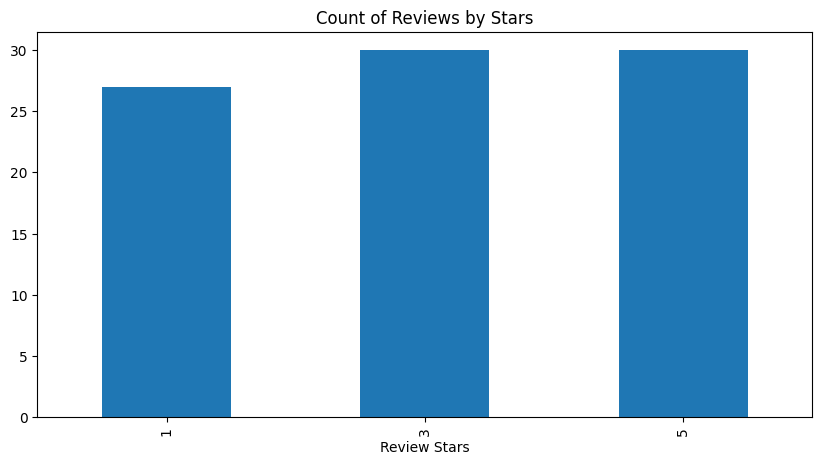

In [4]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

### Roberta

In [5]:
from transformers import pipeline
from transformers import AutoTokenizer

C:\Users\jacqu\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Sentiment Analysis with Roberta

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer=tokenizer)

res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']

    # If the language is English and the token length doesn't exceed the limit
    if langue == 'en':
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1+cpu)
    Python  3.10.11 (you have 3.10.9)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


,Name,grading,date,Text,Target,Language,label (roberta),score (roberta)
ID,,,,,,,,
1,Wissem Smaali,1,11,"To avoid\nThe Piraeus bakery in Vitry, the sal...",0,en,NEGATIVE,0.889870
2,ted tenore,1,4,I specify the star I give it only for the croi...,0,en,NEGATIVE,0.558830
3,Sly yo!,1,4,Too bad for the pastry chef who struggles and ...,0,en,NEGATIVE,0.916203
4,Emiie.R D,1,1,Too bad the products are very good but the sal...,0,en,NEGATIVE,0.777332
5,Michael,1,1,"If I could put -1000 I would have, I asked for...",0,en,NEUTRAL,0.500744
...,...,...,...,...,...,...,...,...
3599,sonia bobrie,5,3,Quality service in the dressing room/storage d...,2,en,POSITIVE,0.989260
4482,Aleksander Callaud,5,24,"Very good restaurant, with very friendly staff...",2,en,POSITIVE,0.987408
4483,La fée toute seule,5,10,A safe bet in Beauvais. Good reception and fai...,2,en,POSITIVE,0.952969


## Exportation des données

In [9]:
import csv

chemin_fichier = 'processed_data.csv'

# Exporter le DataFrame dans un fichier CSV
df.to_csv(chemin_fichier, index=False)

## Score du modèle

In [10]:
test_df = pd.read_csv('dataset1.csv', sep=';')
# test_df = pd.read_csv('data.csv')
print(test_df.shape)
test_df.head()

(5015, 5)


,Name,grading,date,Text,Target
0,Alvin Alias,1 star,7 months ago,Over priced and unfriendly staff,NaN
1,Wissem Smaali,1 star,11 months ago,"À éviter\nLe Pirée boulangerie de Vitry , le v...",0
2,ted tenore,1 star,4 months ago,Je précise l’étoile je le donne que pour les c...,0
3,Sly yo!,1 star,4 months ago,Dommage pour le pâtissier qui ce démène et mes...,0
4,Emiie.R D,1 star,a month ago,Dommage les produits sont très bon mais les ve...,0


In [11]:
test_df = test_df.dropna()
test_df.shape

(87, 5)

In [12]:
X_test = test_df['Text']
y_test = test_df['Target']
X_test

1       À éviter\nLe Pirée boulangerie de Vitry , le v...
2       Je précise l’étoile je le donne que pour les c...
3       Dommage pour le pâtissier qui ce démène et mes...
4       Dommage les produits sont très bon mais les ve...
5       Si je pouvais mettre -1000 je l’aurais fait, j...
                              ...                        
3599    Service de qualité au rayon dressing/rangement...
4482    Très bon restaurant, avec un personnel très sy...
4483    Une valeur sûre à Beauvais. Bon accueil et tar...
4484    Très bon burger, et très bonne bière en pressi...
4487    Restaurant sympa et très bon service. Je recom...
Name: Text, Length: 87, dtype: object

In [13]:
# Traduire les phrases en anglais

X_test = X_test.apply(GoogleTranslator(source='auto', target='en').translate)
X_test

1       To avoid\nThe Piraeus bakery in Vitry, the sal...
2       I specify the star I give it only for the croi...
3       Too bad for the pastry chef who struggles and ...
4       Too bad the products are very good but the sal...
5       If I could put -1000 I would have, I asked for...
                              ...                        
3599    Quality service in the dressing room/storage d...
4482    Very good restaurant, with very friendly staff...
4483    A safe bet in Beauvais. Good reception and fai...
4484    Very good burger, and very good draft beer. Go...
4487    Nice restaurant and very good service. I recom...
Name: Text, Length: 87, dtype: object

In [14]:
y_pred = X_test.apply(lambda x: nlp(x)[0]['label'])

In [15]:
# remplacer LABEL_0 par 0, LABEL_1 par 1 et LABEL_2 par 2
y_pred = y_pred.replace('LABEL_0', 0)
y_pred = y_pred.replace('LABEL_1', 1)
y_pred = y_pred.replace('LABEL_2', 2)
y_pred

1       0
2       0
3       0
4       0
5       1
       ..
3599    2
4482    2
4483    2
4484    2
4487    2
Name: Text, Length: 87, dtype: int64

In [16]:
def accuracy(y_test, y_pred):
    return np.mean(y_test == y_pred)

In [17]:
# Remplacer la valeur de la ligne 1515 par 0
y_test = y_test.replace('À', 0)

In [18]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

In [19]:
score = accuracy(y_test, y_pred)
print(f"Accuracy: {score:.2f}")

Accuracy: 0.70
